# 101 XArray
El 20% de los metodos y plantillas que hacen el 80% del trabajo.

In [ ]:
!pip -q install xarray netcdf4 bottleneck cdsapi zarr \
                 scipy scikit-learn torch --upgrade -qqq

In [ ]:
# esto es para acceder a la API de la agencia espacial europea
# dejar tal cual, creara un archivo
!echo "url: https://cds.climate.copernicus.eu/api" >> ~/.cdsapirc
!echo "key: 8ed01691-cb79-45f4-b426-815241203696" >> ~/.cdsapirc

### Helpers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _pick_var(ds):
    """Elige una variable ‘continua’ típica de superficie."""
    for k in ["t2m_C", "t2m", "tp", "swvl1"]:
        if k in ds.data_vars:
            return k
    # fallback: primera variable
    return list(ds.data_vars)[0]

def _ensure_celsius(da):
    """Convierte Kelvin→°C si aplica, manteniendo attrs."""
    units = da.attrs.get("units", "")
    if units.lower() in ["k", "kelvin"]:
        out = da - 273.15
        out.attrs.update(da.attrs)
        out.attrs["units"] = "°C"
        return out
    return da

def _pick_point_coords(ds, prefer_lat=-33.45, prefer_lon=-70.65):
    """Busca el punto más cercano a coords favoritas; si falla, usa medianas."""
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"
    try:
        latv = float(ds[lat_name].sel({lat_name: prefer_lat}, method="nearest"))
        lonv = float(ds[lon_name].sel({lon_name: prefer_lon}, method="nearest"))
        return lat_name, lon_name, latv, lonv
    except Exception:
        latv = float(ds[lat_name].median())
        lonv = float(ds[lon_name].median())
        return lat_name, lon_name, latv, lonv

def _assert_dims(da, req=("time","latitude","longitude")):
    missing = [d for d in req if d not in da.dims]
    if missing:
        raise ValueError(f"La variable {da.name} no tiene dims {req}. Dims actuales: {da.dims}")

def _shape_info(tag, x):
    if hasattr(x, "sizes"):
        print(f"[{tag}] dims: {dict(x.sizes)}")
    else:
        try:
            print(f"[{tag}] shape: {tuple(x.shape)}")
        except Exception:
            print(f"[{tag}] tipo: {type(x)}")


# Code

In [ ]:
import xarray as xr

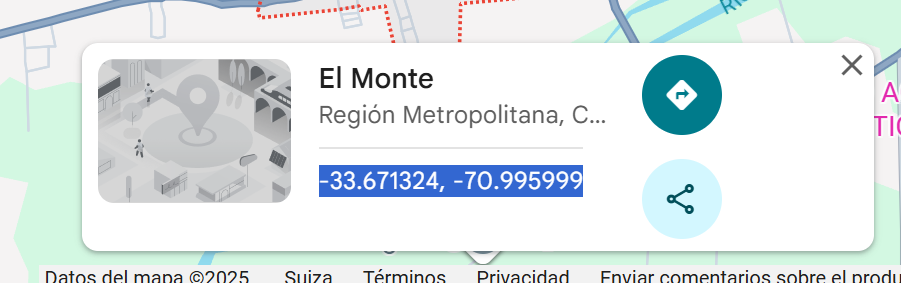

In [ ]:
import cdsapi
import os

c = cdsapi.Client()

fname = "era5_chile.nc"

# Remove the file if it already exists to ensure a fresh download
if os.path.exists(fname):
    os.remove(fname)


# Orden CDS: [N, W, S, E] (grados; negativos = Sur/Sur/Oeste)
punto_monte_interes = [-33.67, -70.99]
area_interes = [-32, -72, -34, -67]
area_chile = [-56, -75, -17, -66]

c.retrieve(
    "reanalysis-era5-single-levels",     # <-- ERA5 (no ERA5-Land)
    {
        "product_type": "reanalysis",    # <-- requerido en ERA5
        "variable": [
            "2m_temperature",            # t2m
            "total_precipitation",       # tp
            "volumetric_soil_water_layer_1",  # swvl1 (disponible en ERA5 SL)
        ],
        "year": ["2024","2025"],
        "month": [f"{m:02d}" for m in range(1, 13)],   # Jul–Dic
        "day": [f"{d:02d}" for d in range(1, 31)],      # días 1–7
        "time": [f"{h:02d}:00" for h in range(0, 24, 8)],  # cada 8 horas

        "area": area_interes,
        "format": "netcdf",
        # opcional: fuerza grilla de salida de ERA5 (por defecto 0.25°)
        # "grid": [0.25, 0.25],
    },
    fname
)

print("Descarga lista:", fname)

# Add a basic check for file size (this might need adjustment based on expected size)
# A more robust check would involve verifying the contents, but this is a quick fix.
expected_min_size_bytes = 100000 # Adjust based on expected file size
if os.path.exists(fname) and os.path.getsize(fname) > expected_min_size_bytes:
    print("File downloaded successfully.")
else:
    print("File download may be incomplete or failed.")

2025-10-06 15:50:35,977 INFO Request ID is 1a10ec37-f98b-4b65-a077-3e8ab7a5f0c3
INFO:ecmwf.datastores.legacy_client:Request ID is 1a10ec37-f98b-4b65-a077-3e8ab7a5f0c3
2025-10-06 15:50:36,117 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-06 15:58:57,470 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-06 16:04:59,647 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


91b2070cb07368a25ee9500a170e8170.zip:   0%|          | 0.00/1.95M [00:00<?, ?B/s]

Descarga lista: era5_chile.nc
File downloaded successfully.


In [ ]:
import zipfile, os

zip_path = fname # en realidad es un zip
out_dir = "data_era"

os.makedirs(out_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(out_dir)

print("Contenido descomprimido:")

fnames = os.listdir(out_dir)
for fname in fnames:
    print(fname)
    ds = xr.open_dataset(f"/content/{out_dir}/{fname}", engine='netcdf4')
    print("Variables:", list(ds.data_vars))

Contenido descomprimido:
data_stream-oper_stepType-accum.nc
Variables: ['tp']
data_stream-oper_stepType-instant.nc
Variables: ['t2m', 'swvl1']


visualización rapida de una variable

In [ ]:
import numpy as np

# Carga
ds_inst = xr.open_dataset(f"{out_dir}/data_stream-oper_stepType-instant.nc",
                          engine="netcdf4", chunks={"time": 240})  # t2m, swvl1
ds_acc  = xr.open_dataset(f"{out_dir}/data_stream-oper_stepType-accum.nc",
                          engine="netcdf4", chunks={"time": 240})    # tp (acumulada)

# Alinear en tiempo/espacio
ds_inst = ds_inst.sortby("valid_time")
ds_acc  = ds_acc.sortby("valid_time")

# Asegurar mismo recorte/regilla
ds = xr.align(ds_inst, ds_acc, join="inner")
ds_inst, ds_acc = ds

# podemos elegir uno por simplisidad para actuar aqui
ds = ds_inst

In [ ]:
# --- la sintaxis es similar a pandas si quieres crear nuevas columnas ---
# Suelen encontrarse en kelvin, es posible tomar una columna y crear otra nueva
if "t2m" in ds:
    ds["t2m_C"] = ds["t2m"]- 273.15


In [ ]:
# ---- Data cleaning ... ----
# Normaliza nombres y orden de latitud (ERA5 usa 'latitude' decreciente)
if "latitude" in ds.coords:
    ds = ds.sortby("latitude")  # ascendente
if "lon" in ds.coords and "longitude" not in ds.coords:
    ds = ds.rename({"lon": "longitude"})
if "lat" in ds.coords and "latitude" not in ds.coords:
    ds = ds.rename({"lat": "latitude"})

# ERA5 usa valid_time lo que es incomodo y poco convencional
ds = ds.rename({"valid_time": "time"})

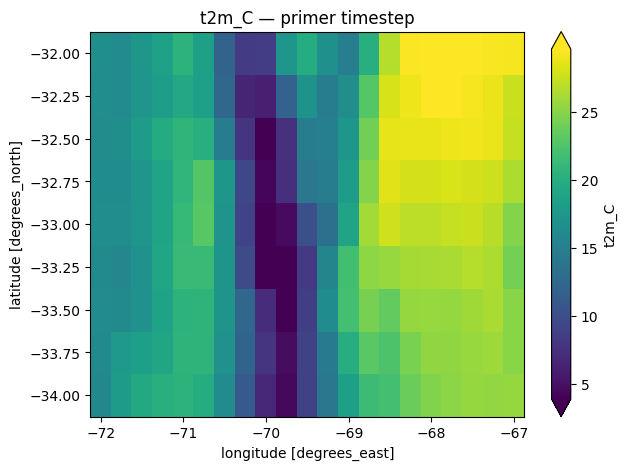

[Serie puntual] dims: {'time': 443}


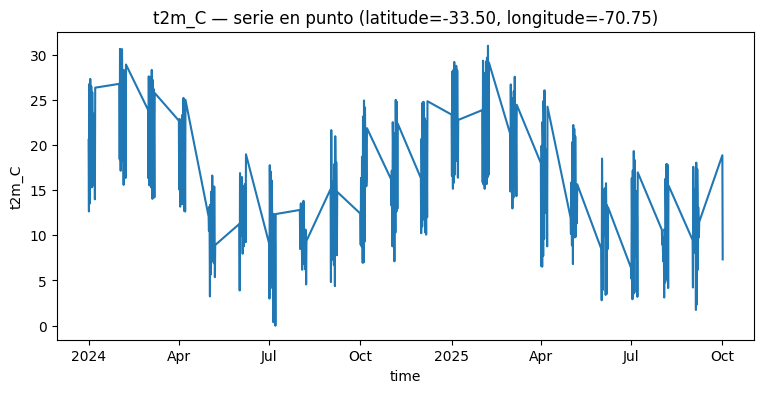

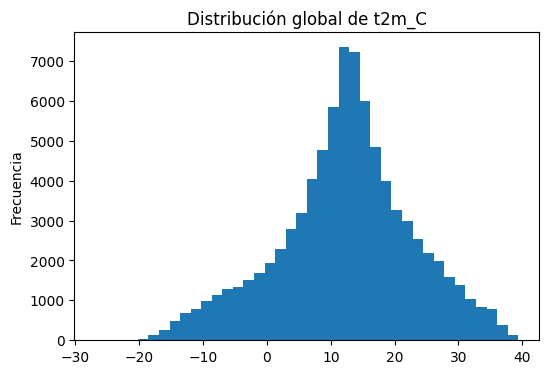

In [ ]:
# --- Selección de variable y verificación
var = _pick_var(ds)
da = _ensure_celsius(ds[var]).rename(var)
_assert_dims(da)

# --- Mapa del primer timestep
fig = plt.figure(figsize=(7,5))
da.isel(time=0).plot.imshow(robust=True)
plt.title(f"{da.name} — primer timestep")
plt.show()

# --- Serie temporal en un punto representativo
lat_name, lon_name, latv, lonv = _pick_point_coords(ds)
pt = da.sel({lat_name: latv, lon_name: lonv}, method="nearest")
_shape_info("Serie puntual", pt)
fig = plt.figure(figsize=(9,4))
pt.plot()
plt.title(f"{da.name} — serie en punto ({lat_name}={latv:.2f}, {lon_name}={lonv:.2f})")
plt.xlabel("time"); plt.ylabel(da.attrs.get("long_name", da.name))
plt.show()

# --- Histograma de valores (todas las grillas y tiempos)
fig = plt.figure(figsize=(6,4))
da.values.ravel()[::50]  # acceso provoca carga; ok para tamaños moderados
plt.hist(da.values.ravel(), bins=40)
plt.title(f"Distribución global de {da.name}")
plt.xlabel(da.attrs.get("units","")); plt.ylabel("Frecuencia")
plt.show()


### Estadistica Temporal y Espacial
Vamos a tomar promedios y variacionales, por grilla y ventana de tiempo

In [ ]:
# Mensual
ds_mensual = ds.resample(time="1MS").mean()

# Media estacional (DJF/MAM/JJA/SON)
ds_est = ds.groupby("time.season").mean()

# Rolling/ventanas móviles (p.ej. 7 días)
roll = ds.rolling(time=7, center=True).mean()

# Anomalías respecto a climatología mensual  (ajusta el rango)
base = ds.sel(time=slice(ds.time.min(), ds.time.max()))
clim_m = base.groupby("time.month").mean()
anom = ds.groupby("time.month") - clim_m

# Desviación estándar temporal (por celda)
std_t = ds.std(dim="time")


Shape of clim_m[da_crudo.name]: (12, 9, 21)
Content of clim_m[da_crudo.name]: <xarray.DataArray 't2m_C' (month: 12, latitude: 9, longitude: 21)> Size: 9kB
dask.array<concatenate, shape=(12, 9, 21), dtype=float32, chunksize=(1, 9, 21), chunktype=numpy.ndarray>
Coordinates:
    number     (month) int64 96B 0 0 0 0 0 0 0 0 0 0 0 0
  * latitude   (latitude) float64 72B -34.0 -33.75 -33.5 ... -32.5 -32.25 -32.0
  * longitude  (longitude) float64 168B -72.0 -71.75 -71.5 ... -67.25 -67.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12


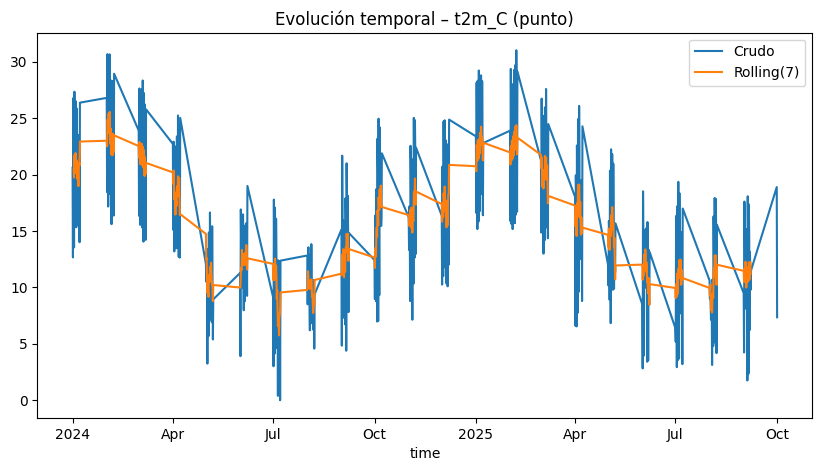

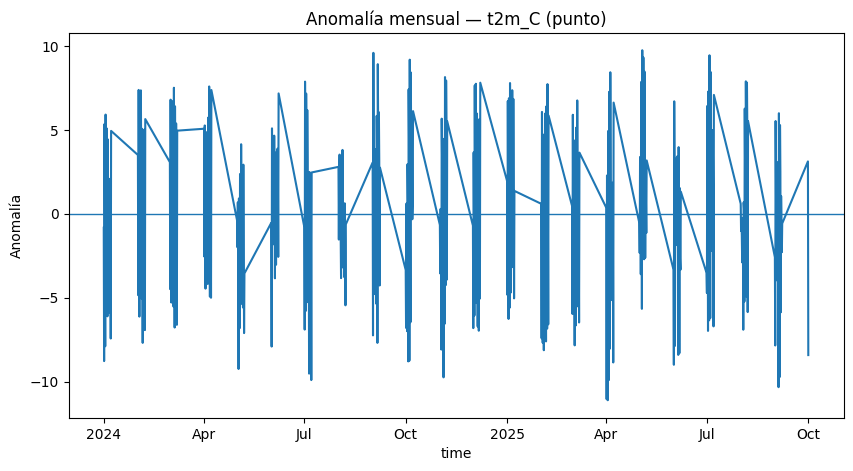

In [ ]:
# Variables derivadas ya existen: roll (Dataset), anom (Dataset), clim_m (Dataset)
da_crudo = _ensure_celsius(ds[_pick_var(ds)])
_assert_dims(da_crudo)

# Climatología mensual “en el punto” (media de cada mes)
# Add print statements to diagnose the error
print("Shape of clim_m[da_crudo.name]:", clim_m[da_crudo.name].shape)
print("Content of clim_m[da_crudo.name]:", clim_m[da_crudo.name])

roll_px = roll[da_crudo.name].sel({lat_name: latv, lon_name: lonv}, method="nearest")
anom_px = anom[da_crudo.name].sel({lat_name: latv, lon_name: lonv}, method="nearest")

# Serie comparativa
fig = plt.figure(figsize=(10,5))
da_crudo.sel({lat_name: latv, lon_name: lonv}, method="nearest").plot(label="Crudo")
roll_px.plot(label="Rolling(7)")
plt.legend()
plt.title(f"Evolución temporal – {da_crudo.name} (punto)")
plt.xlabel("time"); plt.ylabel(da_crudo.attrs.get("units",""))
plt.show()

# Anomalía (tiempo) vs climatología mensual (barras)
fig = plt.figure(figsize=(10,5))
anom_px.plot()
plt.axhline(0, linewidth=1)
plt.title(f"Anomalía mensual — {da_crudo.name} (punto)")
plt.xlabel("time"); plt.ylabel("Anomalía")
plt.show()


#### 2.2. Agregación espacial por ventanas (coarsen = promedios en bloques)

In [ ]:
# Promedio espacial por ventanas (p.ej. cada 2x2 celdas)
coarse = ds.coarsen(latitude=2, longitude=2, boundary="trim").mean()


#### 2.3. Downsampling espacial (interpolación a rejilla más fina)

In [ ]:
# Interpola a una rejilla más densa (ejemplo: +0.1º)
import numpy as np
new_lat = np.arange(float(ds.latitude.min()), float(ds.latitude.max()) + 1e-9, 0.1)
new_lon = np.arange(float(ds.longitude.min()), float(ds.longitude.max()) + 1e-9, 0.1)
ds_fino = ds.interp(latitude=new_lat, longitude=new_lon)


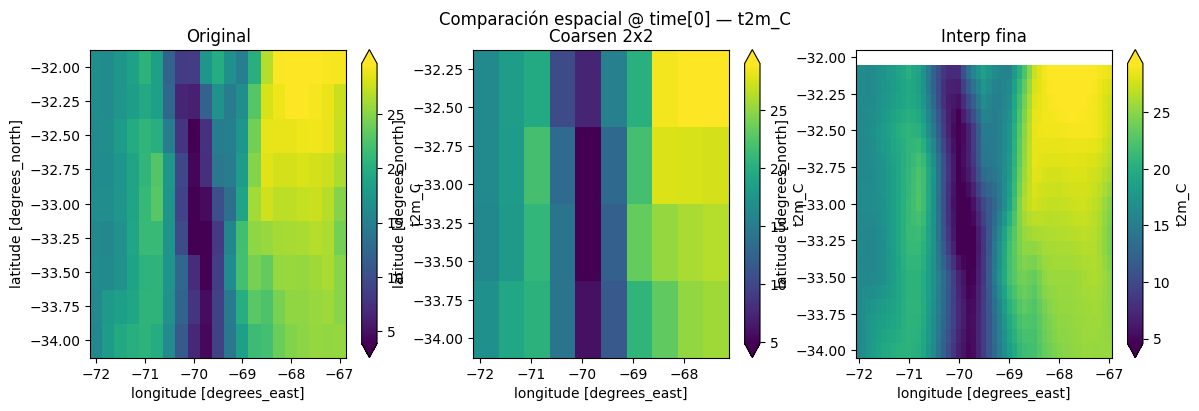

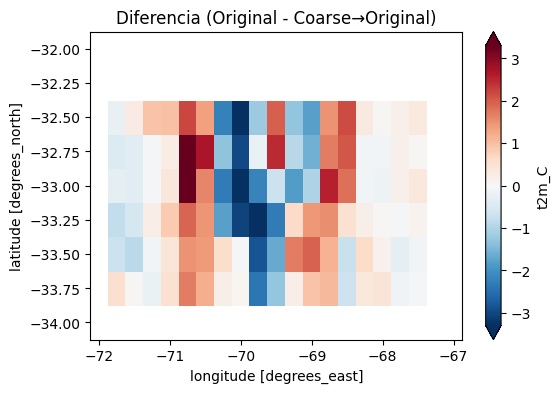

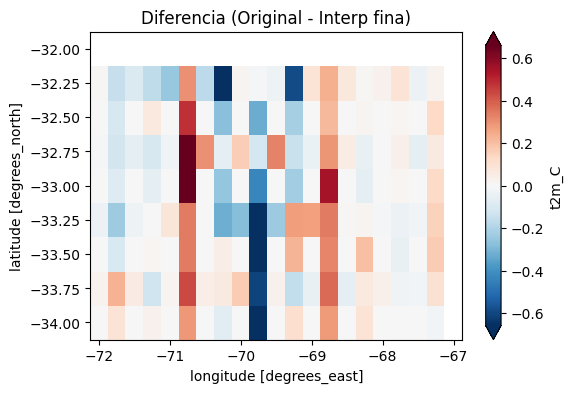

In [ ]:
da0 = ds[da_crudo.name]
coarse0 = coarse[da_crudo.name]
fine0 = ds_fino[da_crudo.name]

t0 = int(0)
fig, axes = plt.subplots(1,3, figsize=(14,4))
da0.isel(time=t0).plot.imshow(ax=axes[0], robust=True); axes[0].set_title("Original")
coarse0.isel(time=t0).plot.imshow(ax=axes[1], robust=True); axes[1].set_title("Coarsen 2x2")
fine0.isel(time=t0).plot.imshow(ax=axes[2], robust=True); axes[2].set_title("Interp fina")
plt.suptitle(f"Comparación espacial @ time[{t0}] — {da_crudo.name}")
plt.show()

# Diferencia (coarse→original re-interpolado a la grilla original para comparar)
coarse_to_orig = coarse0.interp(latitude=da0.latitude, longitude=da0.longitude)
diff = da0.isel(time=t0) - coarse_to_orig.isel(time=t0)
fig = plt.figure(figsize=(6,4))
diff.plot.imshow(robust=True)
plt.title("Diferencia (Original - Coarse→Original)")
plt.show()

# Diferencia (fina-> origianl)
fine_to_orig = fine0.interp(latitude=da0.latitude, longitude=da0.longitude)
diff = da0.isel(time=t0) - fine_to_orig.isel(time=t0)
fig = plt.figure(figsize=(6,4))
diff.plot.imshow(robust=True)
plt.title("Diferencia (Original - Interp fina)")
plt.show()


#### 2.4. Promedios espaciales con pesos de área

In [ ]:
import numpy as np
weights = np.cos(np.deg2rad(ds.latitude))
# Xarray broadcast automático si el nombre de dims coincide
wmean_global = ds.weighted(weights).mean(("latitude", "longitude"))


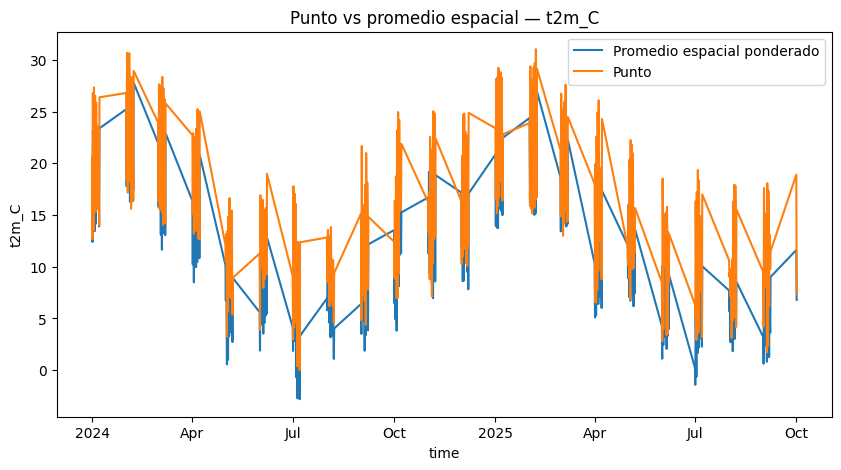

In [ ]:
wmean_var = _ensure_celsius(wmean_global[da_crudo.name])

# Serie global ponderada vs punto
fig = plt.figure(figsize=(10,5))
wmean_var.plot(label="Promedio espacial ponderado")
da_crudo.sel({lat_name: latv, lon_name: lonv}, method="nearest").plot(label="Punto")
plt.legend()
plt.title(f"Punto vs promedio espacial — {da_crudo.name}")
plt.xlabel("time")
plt.show()



[Hovmöller(T,lat)] dims: {'time': 443, 'latitude': 9}


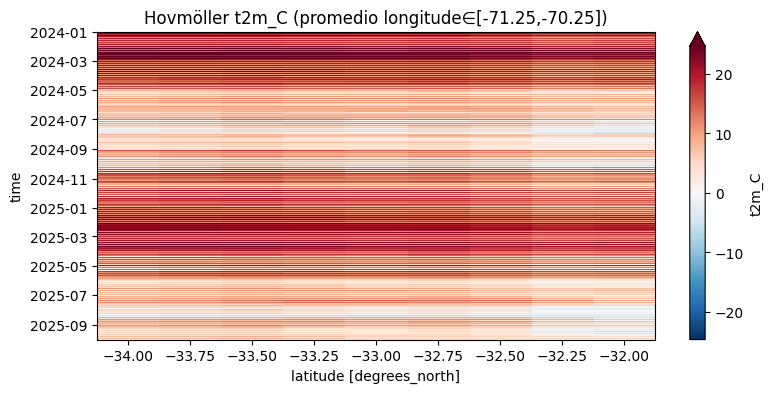

In [ ]:
# Hovmöller (tiempo–latitud) promediando en una franja de longitudes alrededor del punto
lon_slice = slice(lonv-0.5, lonv+0.5)
hov = da_crudo.sel({lon_name: lon_slice}).mean(lon_name)
_shape_info("Hovmöller(T,lat)", hov)
fig = plt.figure(figsize=(9,4))
hov.plot.imshow(robust=True, yincrease=False)
plt.title(f"Hovmöller {da_crudo.name} (promedio {lon_name}∈[{float(lon_slice.start):.2f},{float(lon_slice.stop):.2f}])")
plt.show()


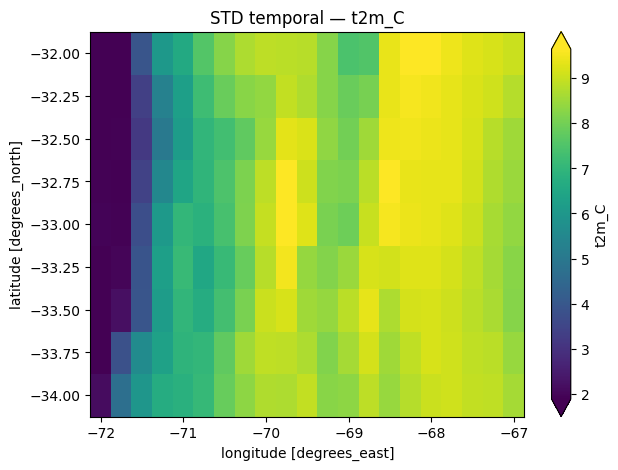

In [ ]:
# Mapa de desviación estándar temporal
fig = plt.figure(figsize=(7,5))
std_map = ds[da_crudo.name].std("time")
std_map.plot.imshow(robust=True)
plt.title(f"STD temporal — {da_crudo.name}")
plt.show()

### 3) Pipeline de scikit-learn (árboles/regresión) con Xarray
La clave es aplanar dims espaciales y mantener la dimensión temporal como “muestras”.

Para pronóstico por componentes (mucho más liviano), primero aplica PCA/SVD al espacio y modela las primeras k componentes; luego reconstruyes al espacio. Abajo lo vemos con SVD.

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(
    n_workers=2,               # súbelo si Colab te da más CPU
    threads_per_worker=2,      # 2–4 suele ir bien
    memory_limit="10GB"
)
client = Client(cluster)
client

/usr/local/lib/python3.12/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41957 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39783
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:41957/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45829'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37837'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:32965 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:32965
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:59450
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36129 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36129
IN

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41957/status,
Dashboard: http://127.0.0.1:41957/status,Workers: 2
Total threads: 4,Total memory: 18.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39783,Workers: 0
Dashboard: http://127.0.0.1:41957/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36129,Total threads: 2
Dashboard: http://127.0.0.1:33855/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:45829,


In [ ]:
import dask.array as da

var = "t2m_C" if "t2m_C" in ds else list(ds.data_vars)[0]
da0 = ds[var]                                   # (time, lat, lon)
X_stack = da0.stack(points=("latitude","longitude")).data  # dask.array: (time, points)

n_lags, horizon = 3, 1

# sliding window sobre el eje tiempo: crea (time, window, points) de forma lazy
from dask.array.lib.stride_tricks import sliding_window_view
Xw = sliding_window_view(X_stack, window_shape=(n_lags+horizon,), axis=0)  # (time-n+1, n_lags+horizon, points)

# Split features/target sin materializar
X_feat = Xw[:, :n_lags, :]                         # (T_eff, n_lags, points)
Y_targ = Xw[:, n_lags + (horizon-1), :]            # (T_eff, points)

# Elimina las primeras (n_lags+horizon-1) filas (ya lo hizo sliding_window_view)
T_eff = X_feat.shape[0]
# Reordena a 2D: (T_eff, n_lags*points)
X_mat = X_feat.reshape(T_eff, n_lags * X_feat.shape[2])
Y_mat = Y_targ                                     # (T_eff, points)

# Opcional: persistir en memoria del cluster para reutilizar
X_mat_p = X_mat.persist()
Y_mat_p = Y_mat.persist()


In [ ]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Split temporal
n = X_mat_p.shape[0]
split = int(0.8 * n)
Xtr = X_mat_p[:split]; Xte = X_mat_p[split:]
Ytr = Y_mat_p[:split]; Yte = Y_mat_p[split:]

# # Usa el backend Dask para distribuir trabajos joblib (n_jobs=-1 usa todos los workers)
# from dask.distributed import get_client
# client = get_client()

# Materializa los datos a NumPy antes de pasarlos al modelo
Xtr_np = Xtr.compute() if hasattr(Xtr, "compute") else Xtr
Ytr_np = Ytr.compute() if hasattr(Ytr, "compute") else Ytr
Xte_np = Xte.compute() if hasattr(Xte, "compute") else Xte
Yte_np = Yte.compute() if hasattr(Yte, "compute") else Yte


base = RandomForestRegressor(
    n_estimators=200, n_jobs=-1, random_state=0, max_depth=None
)
model = MultiOutputRegressor(base, n_jobs=-1)
model.fit(Xtr_np, Ytr_np)

pred = model.predict(Xte_np)
rmse = mean_squared_error(Yte_np, pred)
print("RMSE:", rmse)

RMSE: 1.7595071976116579


### 4) SVD/EOF (modos variacionales) con SciPy/Numpy

Calcula anomalías (quita climatología)

Pesa por área (√cos(lat))

Reordena a matriz (time, space)

SVD ⇒ PCs (temporal) + EOFs (patrones espaciales)

Con esto puedes plotear eofk como mapa y PCs.sel(mode=k) como serie temporal.
Si el dominio es grande, puedes usar scipy.sparse.linalg.svds o aplicar SVD a la matriz de covarianza temporal.

In [ ]:
import numpy as np
import scipy.linalg as la

# 4.1. Anomalías mensuales (ejemplo)

# Anomalías respecto a climatología mensual  (ajusta el rango)
base = ds.sel(time=slice(ds.time.min(), ds.time.max()))
clim_m = base.groupby("time.month").mean()
anom = ds.groupby("time.month") - clim_m

da = (anom["t2m_C"] if "t2m_C" in anom else anom[list(anom.data_vars)[0]]).dropna("time", how="all")


In [ ]:
da

<xarray.DataArray 't2m_C' (time: 443, latitude: 9, longitude: 21)> Size: 335kB
dask.array<sub, shape=(443, 9, 21), dtype=float32, chunksize=(1, 9, 21), chunktype=numpy.ndarray>
Coordinates:
    number     (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time       (time) datetime64[ns] 4kB 2024-01-01 ... 2025-10-01T08:00:00
  * latitude   (latitude) float64 72B -34.0 -33.75 -33.5 ... -32.5 -32.25 -32.0
  * longitude  (longitude) float64 168B -72.0 -71.75 -71.5 ... -67.25 -67.0
    expver     (time) <U4 7kB dask.array<chunksize=(443,), meta=np.ndarray>
    month      (time) int64 4kB 1 1 1 1 1 1 1 1 1 1 1 ... 9 9 9 9 9 9 9 9 10 10

In [ ]:

# 4.2. Pesar por área
lat = da["latitude"]
w = np.sqrt(np.cos(np.deg2rad(lat)))
A = (da * w).stack(points=("latitude","longitude"))  # (time, space)

# 4.3. SVD (economy)
X = A.fillna(0.0).to_numpy()        # (T,S)
X = X - X.mean(0, keepdims=True)    # quita media espacial residual
U, s, Vt = la.svd(X, full_matrices=False)  # X ~ U @ diag(s) @ Vt

# PCs y EOFs (re-escala)
PCs  = xr.DataArray(U * s, dims=("time","mode"), coords={"time":A.time, "mode":np.arange(len(s))})
EOFs = xr.DataArray(Vt, dims=("mode","points"), coords={"mode":np.arange(len(s)), "points":A.points})

# Mapear EOF k al espacio lat/lon
k = 0
eofk = EOFs.sel(mode=k).unstack("points") / w  # deshacer peso
eofk.name = f"EOF{k+1}"
expl_var = (s**2) / (s**2).sum()
float(expl_var[k])


0.9292158788606819

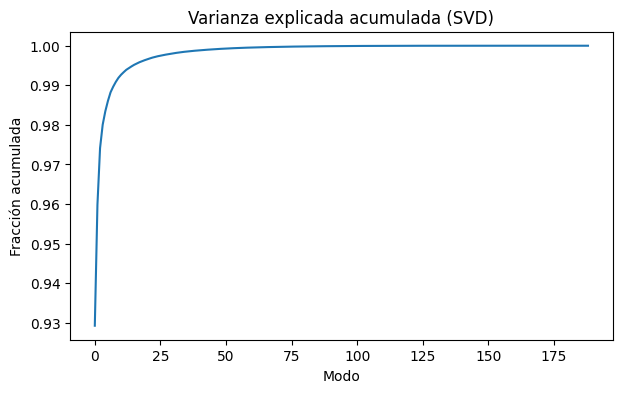

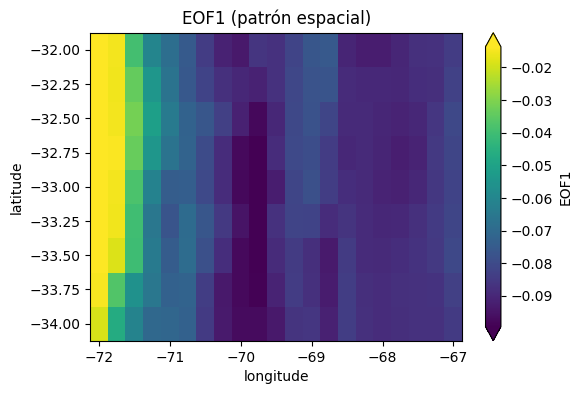

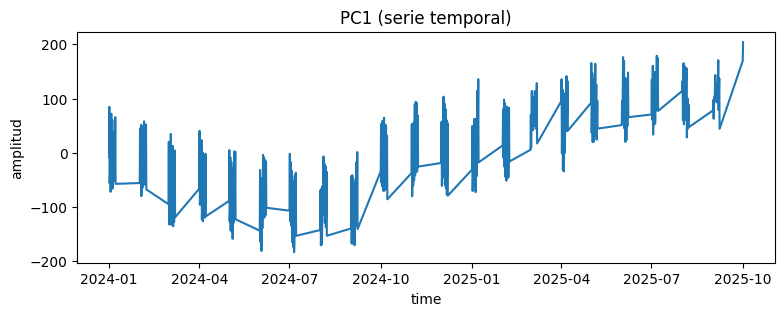

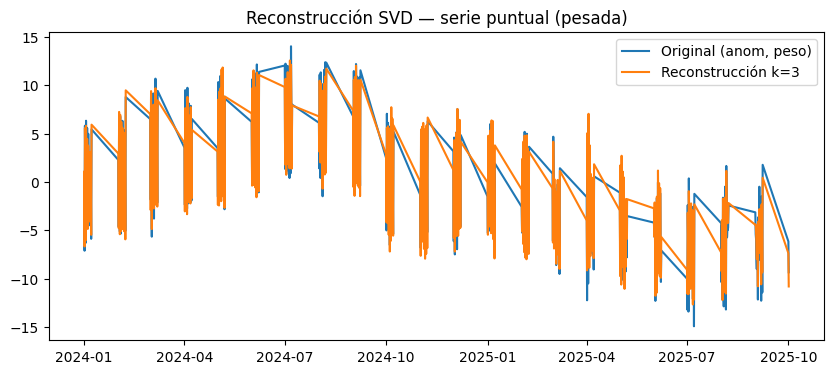

In [ ]:
# Curva de varianza explicada
expl_var = (s**2) / np.sum(s**2)
fig = plt.figure(figsize=(7,4))
plt.plot(np.cumsum(expl_var))
plt.title("Varianza explicada acumulada (SVD)")
plt.xlabel("Modo"); plt.ylabel("Fracción acumulada")
plt.show()

# Mapa EOF1 y serie PC1
fig = plt.figure(figsize=(6,4))
eofk.plot.imshow(robust=True)
plt.title("EOF1 (patrón espacial)")
plt.show()

fig = plt.figure(figsize=(9,3))
plt.plot(PCs.time.values, (PCs.sel(mode=0)).values)
plt.title("PC1 (serie temporal)")
plt.xlabel("time"); plt.ylabel("amplitud")
plt.show()

# Consistencia: reconstrucción aprox usando k modos y comparación en el punto
k = 3
Vk = Vt[:k, :]
Uk = U[:, :k]
Sk = np.diag(s[:k])
Xk = Uk @ Sk @ Vk  # (T,S)

# Recuperar serie en el punto (índice del punto más cercano)
stacked = (anom[da_crudo.name] * np.sqrt(np.cos(np.deg2rad(da_crudo.latitude)))).stack(points=("latitude","longitude")).fillna(0)
# índice del punto seleccionado
pt_idx = int(np.argmin(np.abs(stacked.points.to_index().get_level_values("latitude")-latv)
                       + np.abs(stacked.points.to_index().get_level_values("longitude")-lonv)))
reco_pt = Xk[:, pt_idx]
orig_pt = stacked[:, pt_idx].to_numpy()

fig = plt.figure(figsize=(10,4))
plt.plot(stacked.time.values, orig_pt, label="Original (anom, peso)")
plt.plot(stacked.time.values, reco_pt, label=f"Reconstrucción k={k}")
plt.legend(); plt.title("Reconstrucción SVD — serie puntual (pesada)")
plt.show()


### 5) PyTorch: denso y LSTM desde Xarray

#### 5.1. Dataset deslizante (ventanas temporales)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SlidingDataset(Dataset):
    def __init__(self, X_2d, n_lags=3, horizon=1):
        # X_2d: (time, features) = (T, S) (p.ej. campos apilados)
        self.X = X_2d.astype("float32")
        self.n = n_lags; self.h = horizon
        self.T = self.X.shape[0]

    def __len__(self): return self.T - self.n - self.h
    def __getitem__(self, i):
        x = self.X[i:i+self.n]      # (n, S)
        y = self.X[i+self.n+self.h] # (S,)
        return torch.from_numpy(x), torch.from_numpy(y)

X_space = da.stack(points=("latitude", "longitude"))
X_np = X_space.to_numpy().astype("float32")
train_ds = SlidingDataset(X_np[:split+4], n_lags=3, horizon=1)
test_ds  = SlidingDataset(X_np[split-3:], n_lags=3, horizon=1)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False)


#### 5.2. Modelo denso simple (pronóstico a +1 sobre todo el campo)

Ttr 354
Tte 89


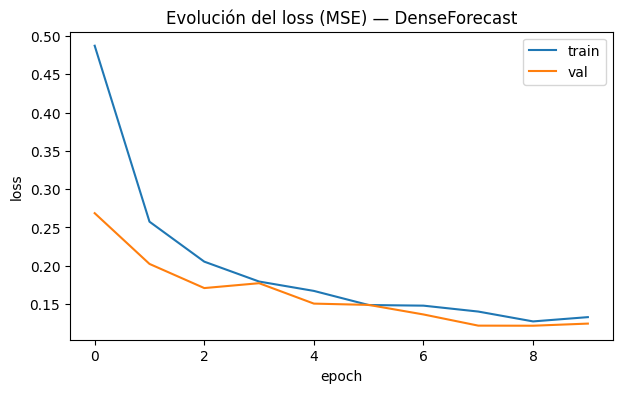

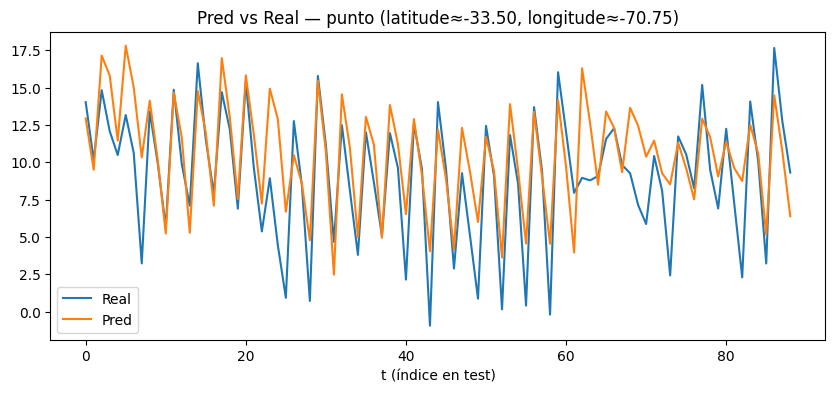

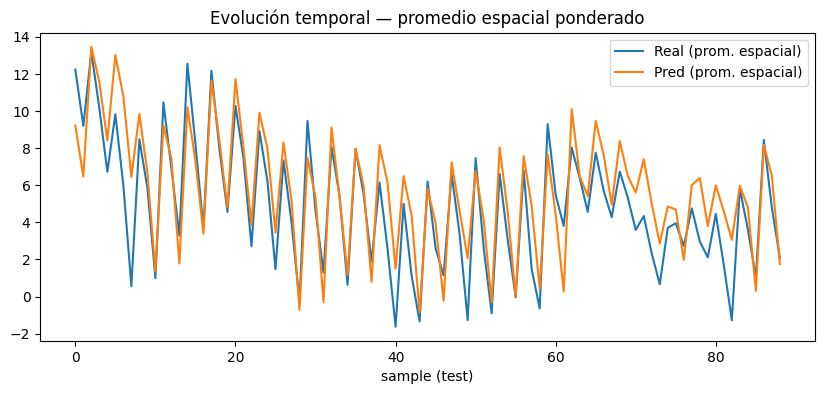

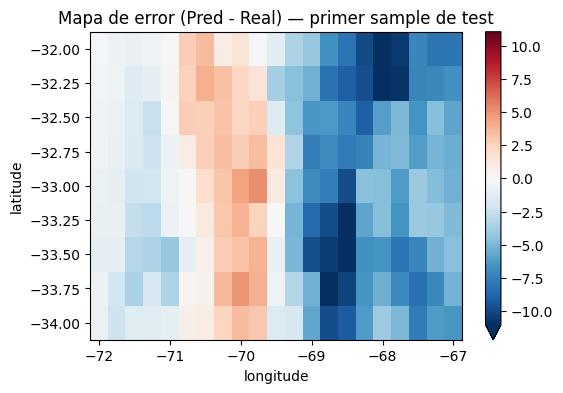

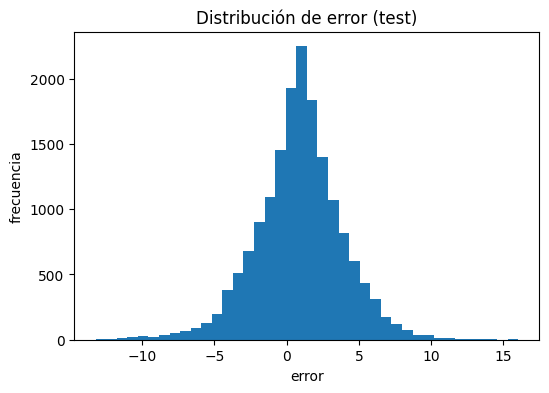

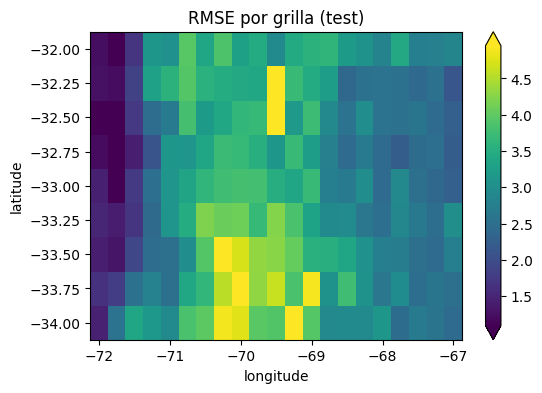

In [ ]:
var = _pick_var(ds)
da0 = _ensure_celsius(ds[var])
if "latitude" in da0.coords:
    da0 = da0.sortby("latitude")

# 2) Construir (time, points) con stack conservando coords
X_space = da0.stack(points=("latitude", "longitude")).astype("float32").fillna(0)

# 3) Partición temporal (sin fuga de información)
T = X_space.sizes["time"]
train_frac = 0.8
Ttr = int(T * train_frac)  # al menos unas muestras
Tte = T - Ttr
print("Ttr", Ttr)
print("Tte", Tte)
assert Ttr >= 5 and Tte >= 5, "No hay suficientes timesteps para train/test."

# 4) Normalización (mean/std) SOLO con entrenamiento
mu = X_space.isel(time=slice(0, Ttr)).mean("time")
sd = X_space.isel(time=slice(0, Ttr)).std("time")
sd = xr.where(sd < 1e-12, 1.0, sd)

# ---------- Dataset deslizante con normalización ----------
class SlidingStdDataset(Dataset):
    def __init__(self, X_da: xr.DataArray, mu: xr.DataArray, sd: xr.DataArray, n_lags=3, horizon=1):
        """
        X_da: DataArray (time, points) ya stackeado y float32
        mu, sd: DataArray (points) para normalizar
        """
        self.n = int(n_lags)
        self.h = int(horizon)
        self.points = X_da["points"].to_numpy()
        # normaliza
        Xn = (X_da - mu) / sd
        self.X = Xn.to_numpy().astype("float32")  # (T, S)
        self.mu = mu.to_numpy().astype("float32")
        self.sd = sd.to_numpy().astype("float32")

    def __len__(self):
        return self.X.shape[0] - self.n - self.h

    def __getitem__(self, i):
        # x: (n_lags, S), y: (S,)
        x = self.X[i : i + self.n, :]
        y = self.X[i + self.n + self.h, :]
        return torch.from_numpy(x), torch.from_numpy(y)

# Hiperparámetros de ventana
n_lags  = 3
horizon = 1

# 5) Construye datasets: test empieza unos pasos antes para continuidad de lags
train_ds = SlidingStdDataset(X_space.isel(time=slice(0, Ttr)), mu, sd, n_lags=n_lags, horizon=horizon)
test_ds  = SlidingStdDataset(X_space.isel(time=slice(Ttr - (n_lags + horizon), None)), mu, sd, n_lags=n_lags, horizon=horizon)

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
val_dl   = DataLoader(train_ds, batch_size=256, shuffle=False, drop_last=False)  # validación rápida en train (holdout opcional)
test_dl  = DataLoader(test_ds,  batch_size=256, shuffle=False, drop_last=False)

# ---------- Modelo denso (Flatten n_lags*S -> S) ----------
# Inferir dimensiones desde un batch
xb0, yb0 = next(iter(train_dl))
_, n_lags_in, S = xb0.shape[0], xb0.shape[1], xb0.shape[2]
in_features  = n_lags_in * S
out_features = S

class DenseForecast(torch.nn.Module):
    def __init__(self, in_f, out_f, hidden=1024, p_drop=0.1):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Flatten(),                # (B, n_lags, S) -> (B, n_lags*S)
            torch.nn.Linear(in_f, hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(p_drop),
            torch.nn.Linear(hidden, out_f)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseForecast(in_features, out_features, hidden=1024, p_drop=0.1).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=2)
loss_fn = torch.nn.MSELoss()

# ---------- Entrenamiento con validación ----------
EPOCHS = 10
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    run = 0.0; nb = 0
    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        run += float(loss.detach()); nb += 1
    train_losses.append(run/max(1,nb))

    # Val
    model.eval()
    vrun = 0.0; vnb = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            vloss = loss_fn(pred, yb)
            vrun += float(vloss); vnb += 1
    val_loss = vrun/max(1,vnb)
    val_losses.append(val_loss)
    sched.step(val_loss)

# ---------- Plots: curva de pérdida (train/val) ----------
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("Evolución del loss (MSE) — DenseForecast")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()

# ---------- Evaluación en test (des-normalizado) ----------
model.eval()
Y_true_list, Y_pred_list = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()   # (B, S) normalizado
        yb   = yb.cpu().numpy()          # (B, S) normalizado
        # des-normaliza a unidades originales
        pred_den = pred * test_ds.sd + test_ds.mu
        yb_den   = yb   * test_ds.sd + test_ds.mu
        Y_pred_list.append(pred_den)
        Y_true_list.append(yb_den)

Y_pred_np = np.vstack(Y_pred_list)  # (Ntest, S)
Y_true_np = np.vstack(Y_true_list)  # (Ntest, S)

# ---------- Visualizaciones pedagógicas ----------
# 1) Pred vs Real en un punto espacial concreto (elige el más cercano a una coord)
lat_name, lon_name, latv, lonv = _pick_point_coords(ds)
# buscar el índice del punto (lat, lon) más cercano dentro del MultiIndex X_space.points
points_index = X_space.points.to_index()
lat_levels = points_index.get_level_values(0)  # latitude
lon_levels = points_index.get_level_values(1)  # longitude
pt_j = int(np.argmin(np.abs(lat_levels - latv) + np.abs(lon_levels - lonv)))

plt.figure(figsize=(10,4))
plt.plot(Y_true_np[:, pt_j], label="Real")
plt.plot(Y_pred_np[:, pt_j], label="Pred")
plt.title(f"Pred vs Real — punto ({lat_name}≈{float(latv):.2f}, {lon_name}≈{float(lonv):.2f})")
plt.xlabel("t (índice en test)"); plt.ylabel(da0.attrs.get("units",""))
plt.legend(); plt.show()

# 2) Promedio espacial (ponderado por cos φ) — Real vs Pred
# reconstruimos DataArray para calcular promedio con pesos de área
pred_da = xr.DataArray(Y_pred_np, coords={"sample": np.arange(Y_pred_np.shape[0]), "points": X_space.points}, dims=("sample","points")).unstack("points")
true_da = xr.DataArray(Y_true_np, coords={"sample": np.arange(Y_true_np.shape[0]), "points": X_space.points}, dims=("sample","points")).unstack("points")
weights = np.cos(np.deg2rad(pred_da.latitude))
pred_mean = pred_da.weighted(weights).mean(("latitude","longitude"))
true_mean = true_da.weighted(weights).mean(("latitude","longitude"))

plt.figure(figsize=(10,4))
true_mean.plot(label="Real (prom. espacial)")
pred_mean.plot(label="Pred (prom. espacial)")
plt.title("Evolución temporal — promedio espacial ponderado")
plt.xlabel("sample (test)"); plt.ylabel(da0.attrs.get("units",""))
plt.legend(); plt.show()

# 3) Mapa del error en un timestep del test (p.ej., el primero)
err_vec = (Y_pred_np[0] - Y_true_np[0])  # (S,)
err_map = xr.DataArray(err_vec, coords={"points": X_space.points}, dims=("points",)).unstack("points")
plt.figure(figsize=(6,4))
err_map.plot.imshow(robust=True)
plt.title("Mapa de error (Pred - Real) — primer sample de test")
plt.show()

# 4) Histograma del error global en test
plt.figure(figsize=(6,4))
plt.hist((Y_pred_np - Y_true_np).ravel(), bins=40)
plt.title("Distribución de error (test)")
plt.xlabel("error"); plt.ylabel("frecuencia")
plt.show()

# 5) (Opcional) RMSE espacial y su mapa
rmse_space = np.sqrt(np.mean((Y_pred_np - Y_true_np)**2, axis=0))  # (S,)
rmse_map = xr.DataArray(rmse_space, coords={"points": X_space.points}, dims=("points",)).unstack("points")
plt.figure(figsize=(6,4))
rmse_map.plot.imshow(robust=True)
plt.title("RMSE por grilla (test)")
plt.show()

#### 5.3. LSTM (secuencia→vector)

Trucos: entrenar sobre PCs (primeras k componentes) reduce muchísimo la dimensión de salida; luego reconstruyes al espacio.

In [ ]:
class LSTMForecast(torch.nn.Module):
    def __init__(self, space_dim, hidden=256, n_layers=1):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=space_dim, hidden_size=hidden,
                                  num_layers=n_layers, batch_first=True)
        self.head = torch.nn.Linear(hidden, space_dim)
    def forward(self, x):              # x: (B, n_lags, S)
        out, _ = self.lstm(x)
        last = out[:, -1, :]           # (B, hidden)
        return self.head(last)         # (B, S)

model = LSTMForecast(space_dim=X_np.shape[1])


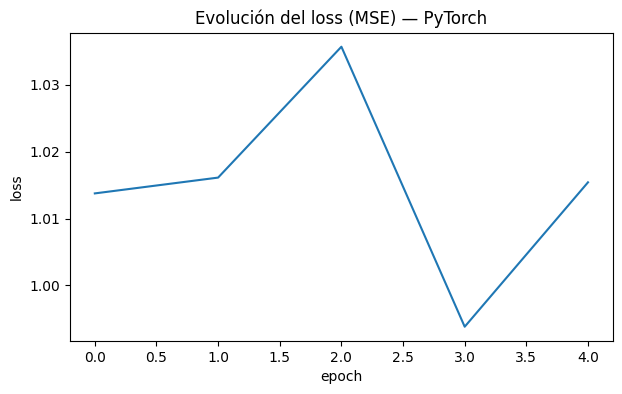

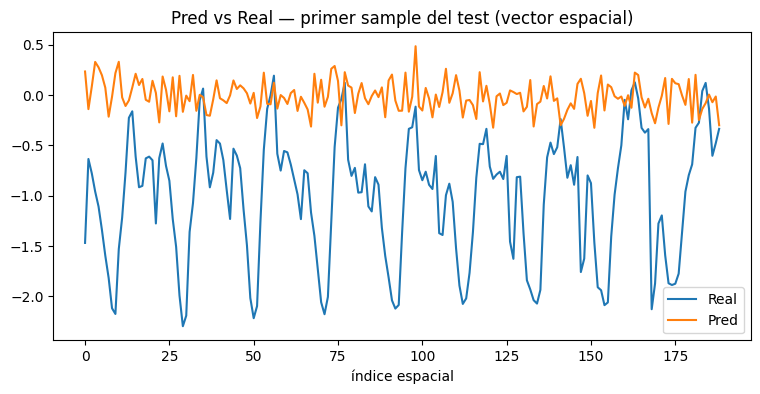

In [ ]:
# Si no guardaste losses arriba, añade tracking
# (ejemplo para DenseForecast — adapta al modelo que uses)
losses = []
for epoch in range(5):
    model.train(); running=0.0; n=0
    for xb, yb in train_dl:
        opt.zero_grad()
        predb = model(xb)
        loss = loss_fn(predb, yb)
        loss.backward(); opt.step()
        running += float(loss.detach()); n += 1
    losses.append(running/max(n,1))

# Curva de pérdida
fig = plt.figure(figsize=(7,4))
plt.plot(losses)
plt.title("Evolución del loss (MSE) — PyTorch")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.show()

# Predicción en un batch de test (punto espacial j)
with torch.no_grad():
    for xb, yb in test_dl:
        yhat = model(xb)  # (B, S)
        break

pt_j = 0
fig = plt.figure(figsize=(9,4))
plt.plot(yb[0].numpy()[:,] if yb.dim()==2 else yb[0].numpy(), label="Real")
plt.plot(yhat[0].numpy()[:,] if yhat.dim()==2 else yhat[0].numpy(), label="Pred")
plt.title("Pred vs Real — primer sample del test (vector espacial)")
plt.xlabel("índice espacial"); plt.ylabel(da_crudo.attrs.get("units",""))
plt.legend(); plt.show()


### 6) Interoperar con SciPy/sklearn (PCA/SVD, filtros, regresión)

PCA/SVD: ya mostrado (SVD). Para PCA con sklearn:

Filtros/transformadas: scipy.signal (suavizados, detrending), scipy.fft para espectros temporales por celda usando xr.apply_ufunc.

Regresores: RandomForestRegressor, GradientBoostingRegressor, Ridge/Lasso para baseline rápidos.

In [ ]:
from sklearn.decomposition import PCA
X = X_space.fillna(0).to_numpy()
pca = PCA(n_components=20, svd_solver="randomized", random_state=0)
Z = pca.fit_transform(X)        # (time, k)
E = pca.components_             # (k, space)
